# Prototypical Netwoks on the Omniglot dataset

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [1]:
import os
import json
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from tqdm import tqdm, tnrange

from sklearn.manifold import TSNE

In [2]:
# --- Фиксация random seed для воспроизводимости ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Проверим устройство (GPU/CPU) ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if DEVICE.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    print("Memory Allocated: {:.1f} GB".format(torch.cuda.memory_allocated(0) / 1024 ** 3))
    print("Memory Cached:    {:.1f} GB".format(torch.cuda.memory_reserved(0) / 1024 ** 3))

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Memory Allocated: 0.0 GB
Memory Cached:    0.0 GB


In [3]:
# --- Количество эпох и размер эпохи (эпизоды) ---
max_epoch    = 5       # всего обучаем 5 «эпох»
epoch_size   = 2000    # в каждой эпохе 2000 эпизодов

# --- Параметры few-shot (прототипический сети) ---
n_way        = 60      # число классов в задаче (N-way)
n_support    = 5       # сколько примеров на класс в поддержке (K-shot)
n_query      = 5       # сколько запросов на класс

# --- Скорость обучения ---
learning_rate = 0.001

# --- При тестировании (будут иные значения n_way и т. д.) ---
test_n_way     = 5     # на этапе теста чаще N-way = 5
test_n_support = 5
test_n_query   = 5
test_episodes  = 1000  # число прогонов (эпизодов) при тесте

## Import data

In [4]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

--2025-06-03 23:15:24--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2025-06-03 23:15:24--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  5.79MB/s    in 1.1s    

2025-06-03 23:15:26 (5.79 MB/s) - ‘images_evaluation.zip’ saved [6

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [5]:
def read_alphabets(alphabet_directory_path):
    """
    Reads all the characters from a given alphabet_directory
    Args:
      alphabet_directory_path (str): path to diretory with files
    Returns:
      datax (np.array): array of path name of images
      datay (np.array): array of labels
    """
    datax = []  # all file names of images
    datay = []  # all class names

    # В папке alphabet_directory_path: набор подпапок, каждая — класс (символ)
    # Мы создаём 4 «поворота» для каждого класса.
    alphabet_name = os.path.basename(os.path.dirname(alphabet_directory_path))
    for character in sorted(os.listdir(alphabet_directory_path)):
        # full path к каждому файлу-изображению
        character_path = os.path.join(alphabet_directory_path, character)
        # (1) оригинальный класс
        cls_label = f"{alphabet_name}/{character}"
        # названия «поворотов»
        labels = [cls_label, cls_label + "_90", cls_label + "_180", cls_label + "_270"]

        # В каждом классе много изображений (28×28, ч/б) - делаем повороты
        imgs_orig   = []
        imgs_rot90  = []
        imgs_rot180 = []
        imgs_rot270 = []

        for img_file in sorted(os.listdir(character_path)):
            img = cv2.imread(os.path.join(character_path, img_file), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28, 28))
            # чтобы получить 3 канала (RGB) для CNN, дублируем в 3 канала:
            img = np.stack([img, img, img], axis=2)

            img90  = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
            img180 = cv2.rotate(img, cv2.ROTATE_180)
            img270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

            imgs_orig.append(img)
            imgs_rot90.append(img90)
            imgs_rot180.append(img180)
            imgs_rot270.append(img270)

        # Добавляем в списки сразу - каждый «поворот» отдельный подкласс
        datax.append(imgs_orig)
        datax.append(imgs_rot90)
        datax.append(imgs_rot180)
        datax.append(imgs_rot270)

        datay.append(labels[0])
        datay.append(labels[1])
        datay.append(labels[2])
        datay.append(labels[3])

    return np.array(datax), np.array(datay)

In [6]:
def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax, datay = None, None
    alphabets = sorted(os.listdir(base_directory))

    for i, alphabet in enumerate(alphabets):
        alphabet_path = os.path.join(base_directory, alphabet) + "/"
        datax_i, datay_i = read_alphabets(alphabet_path)
        if datax is None:
            datax, datay = datax_i, datay_i
        else:
            datax = np.concatenate([datax, datax_i], axis=0)
            datay = np.concatenate([datay, datay_i], axis=0)

    return datax, datay

In [7]:
trainx, trainy = read_images("images_background")

In [8]:
testx, testy = read_images("images_evaluation")

In [9]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((3856, 20, 28, 28, 3), (3856,), (2636, 20, 28, 28, 3), (2636,))

## Create samples

In [10]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    all_classes = np.unique(datay)
    chosen = np.random.choice(all_classes, size=n_way, replace=False)
    sample_images = []

    for cls_label in chosen:
        # найти индекс класса в datay
        idx = np.where(datay == cls_label)[0][0]
        imgs_of_cls = datax[idx]  # shape: (num_examples_per_rotated_class, 28,28,3)

        # Перемешаем и выберем первые n_support + n_query
        perm = np.random.permutation(len(imgs_of_cls))
        selected = imgs_of_cls[perm[: (n_support + n_query) ]]  # shape: (n_support + n_query, 28,28,3)
        sample_images.append(selected)

    # Превращаем в numpy
    sample_images = np.array(sample_images)  # shape: (n_way, n_support + n_query, 28,28,3)
    # преобразуем в torch.Tensor и поменяем порядок каналов: (n_way, n_support+n_query, 3, 28,28)
    sample_images = torch.from_numpy(sample_images).float().permute(0, 1, 4, 2, 3)

    return {
        "images": sample_images.to(DEVICE),
        "n_way": n_way,
        "n_support": n_support,
        "n_query": n_query
    }

In [11]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    imgs = sample["images"].cpu()  # (n_way, n_support+n_query, 3,28,28)
    n_way   = sample["n_way"]
    n_total = sample["n_support"] + sample["n_query"]
    # формируем 4D-тензор для make_grid: (n_way * n_total, 3, 28,28)
    imgs_4d = imgs.view(n_way * n_total, 3, 28, 28)
    grid = torchvision.utils.make_grid(imgs_4d, nrow=n_total, normalize=True, pad_value=1)
    # из (3,H,W) → (H,W,3)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

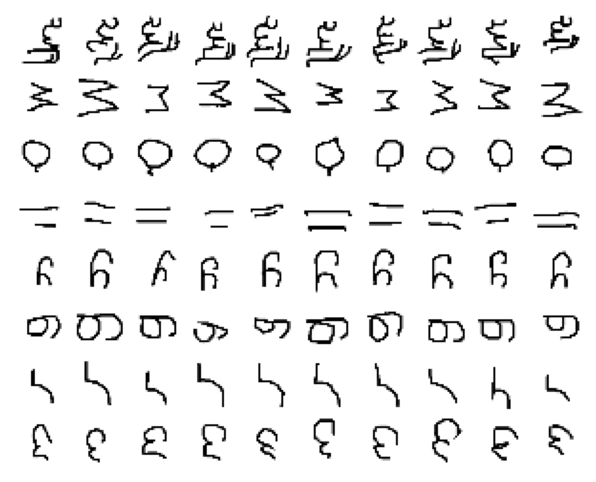

In [12]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example)

In [13]:
sample_example["images"].shape

torch.Size([8, 10, 3, 28, 28])

## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [14]:
def euclidean_dist(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Вычисляет попарные (L2)^2 расстояния между всеми векторами из x и y.
    x: (N, D), y: (M, D) → возвращает (N, M)
    """
    n, d = x.shape
    m, _ = y.shape
    # расширим x до (N, M, D) и y до (N, M, D), после чего разность по последнему измерению
    x_ext = x.unsqueeze(1).expand(n, m, d)
    y_ext = y.unsqueeze(0).expand(n, m, d)
    return torch.pow(x_ext - y_ext, 2).sum(dim=2)

In [15]:
class EncoderBlock(nn.Module):
    """
    Базовый блок: Conv2d → BatchNorm → ReLU → MaxPool
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

In [16]:
class EncoderCNN(nn.Module):
    """
    4-слойный сверточный энкодер (3 блока hid_dim → hid_dim, затем hid_dim → z_dim):
    Вход: (3, 28, 28) → выход: (z_dim)
    """
    def __init__(self, in_channels: int, hid_dim: int, z_dim: int):
        super().__init__()
        blocks = []
        # 1-й блок: 3 → hid_dim
        blocks.append(EncoderBlock(in_channels, hid_dim))
        # 2-й и 3-й блок: hid_dim → hid_dim
        for _ in range(2):
            blocks.append(EncoderBlock(hid_dim, hid_dim))
        # 4-й блок: hid_dim → z_dim
        blocks.append(EncoderBlock(hid_dim, z_dim))

        self._blocks = nn.ModuleList(blocks)
        self.flatten = nn.Flatten()  # чтобы получить (batch_size, z_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, 3, 28, 28)
        for block in self._blocks:
            x = block(x)
        # на выходе: (batch, z_dim, 1, 1) → flatten → (batch, z_dim)
        out = self.flatten(x)
        return out

### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [17]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encoding the images in sample
            n_way (int): number of classes in a classification task
            n_support (int): number of labeled examples per class in the support set
            n_query (int): number of labeled examples per class in the query set
        """
        super().__init__()
        self.encoder = encoder.to(DEVICE)

    def parse_feature(self, X: torch.Tensor, n_support: int):
        """
        Делит X по поддержке (support) и запросам (query).
        X shape: (n_way, n_support+n_query, 3,28,28)
        Возвращает: x_support, x_query (0-й размер: n_way × n_support и n_way × n_query)
        """
        x_support = X[:, :n_support]
        x_query   = X[:, n_support:]
        return x_support, x_query

    def set_forward(self, X: torch.Tensor, n_way: int, n_support: int, n_query: int) -> torch.Tensor:
        """
        Получает X (n_way, n_support+n_query, 3,28,28), возвращает логиты scores (n_way*n_query, n_way).
        """
        # разделим на support и query
        x_sup, x_q = self.parse_feature(X, n_support)
        # выровняем для подачи в encoder: (n_way*n_support, 3,28,28), (n_way*n_query,3,28,28)
        x_sup = x_sup.contiguous().view(n_way * n_support, 3, 28, 28)
        x_q   = x_q.contiguous().view(n_way * n_query,   3, 28, 28)

        # объединяем для одинарного прохода через encoder
        x_all = torch.cat([x_sup, x_q], dim=0).to(DEVICE)
        f_all = self.encoder(x_all)  # (n_way*n_support + n_way*n_query, z_dim)

        z_dim = f_all.size(-1)
        # извлекаем прототипы: среднее по каждому классу support
        f_sup = f_all[: n_way * n_support].view(n_way, n_support, z_dim)
        f_proto = f_sup.mean(dim=1)  # (n_way, z_dim)

        # извлекаем запросы
        f_query = f_all[n_way * n_support :]  # (n_way*n_query, z_dim)

        # вычисляем попарные расстояния (n_way*n_query, n_way)
        dists = euclidean_dist(f_query, f_proto)  # (n_way*n_query, n_way)
        scores = -dists  # чем меньше dist, тем выше score
        return scores

    def set_forward_loss(self, sample: dict):
        """
        sample: {
          "images": Tensor(n_way, n_support+n_query, 3,28,28),
          "n_way": int, "n_support": int, "n_query": int
        }
        Возвращает (loss, metrics_dict) где metrics_dict = {"loss": float, "acc": float, "y_hat": Tensor}
        """
        images   = sample["images"]
        n_way    = sample["n_way"]
        n_supp   = sample["n_support"]
        n_query  = sample["n_query"]

        # y_query shape: (n_way, n_query, 1), метка i-го класса
        y_query = torch.arange(n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).to(DEVICE)

        scores = self.set_forward(images, n_way, n_supp, n_query)
        # scores: (n_way*n_query, n_way) → log-softmax → (n_way, n_query, n_way)
        logit = F.log_softmax(scores, dim=1).view(n_way, n_query, n_way)

        # вычитаем «отрицание logit в нужной позиции» и усредняем → loss
        loss_val = -logit.gather(2, y_query).squeeze().view(-1).mean()

        # предсказания: y_hat shape (n_way, n_query)
        _, y_hat = logit.max(dim=2)

        # точность: сравниваем y_hat с y_query.squeeze()
        acc_val = (y_hat == y_query.squeeze()).float().mean()

        return loss_val, {"loss": loss_val.item(), "acc": acc_val.item(), "y_hat": y_hat}

In [18]:
def load_protonet_conv(**kwargs):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    x_dim = kwargs["x_dim"]
    hid_dim = kwargs["hid_dim"]
    z_dim = kwargs["z_dim"]

    encoder = EncoderCNN(x_dim[0], hid_dim, z_dim).to(DEVICE)

    return ProtoNet(encoder).to(DEVICE)

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [19]:
wandb.login()

wandb: Currently logged in as: d3c3453d (d3c3453d-mipt) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [20]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size, log_wandb: bool = False):
    """
    Trains the protonet
    Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
    """
    if log_wandb:
        wandb.init(project="hw4", name="omniglot_protonet")

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

    for epoch in range(1, max_epoch + 1):
        running_loss = 0.0
        running_acc  = 0.0

        with tqdm(total=epoch_size, desc=f"Epoch {epoch}/{max_epoch}") as pbar:
            for episode in range(epoch_size):
                # формируем один эпизод
                sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
                optimizer.zero_grad()

                loss, metrics = model.set_forward_loss(sample)
                loss.backward()
                optimizer.step()

                running_loss += metrics["loss"]
                running_acc  += metrics["acc"]

                pbar.set_postfix({"loss": f"{metrics['loss']:.4f}", "acc": f"{metrics['acc']:.4f}"})
                pbar.update()

        # по окончании эпохи: вычисляем средние
        epoch_loss = running_loss / epoch_size
        epoch_acc  = running_acc  / epoch_size
        print(f"→ Epoch {epoch} done. Avg Loss: {epoch_loss:.4f}, Avg Acc: {epoch_acc:.4f}")

        if log_wandb:
            wandb.log({"epoch_loss": epoch_loss, "epoch_acc": epoch_acc,
                       "learning_rate": scheduler.get_last_lr()[0]}, step=epoch)

        scheduler.step()

    # После всего обучения сохраняем модель
    torch.save(model.state_dict(), "model_omniglot.pt")
    print("Модель сохранена в model_omniglot.pt")

In [21]:
# Читаем данные
train_folder = "images_background"
test_folder = "images_evaluation"

trainx, trainy = read_images(train_folder)
testx,  testy  = read_images(test_folder)

print("Всего классов в train:", len(trainy))
print("Всего классов в test:",  len(testy))


# Инициализируем модель, оптимизатор
model = load_protonet_conv(x_dim=(3, 28, 28), hid_dim=64, z_dim=64)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Всего классов в train: 3856
Всего классов в test: 2636


In [22]:
%%time

# Запускаем тренировочный цикл
train(  model, optimizer,
        trainx, trainy,
        n_way, n_support, n_query,
        max_epoch, epoch_size,
        log_wandb=True)

Epoch 1/5: 100%|██████████| 2000/2000 [01:03<00:00, 31.45it/s, loss=0.0378, acc=0.9900] 


→ Epoch 1 done. Avg Loss: 0.1163, Avg Acc: 0.9639


Epoch 2/5: 100%|██████████| 2000/2000 [01:00<00:00, 32.96it/s, loss=0.0238, acc=0.9933] 


→ Epoch 2 done. Avg Loss: 0.0461, Avg Acc: 0.9835


Epoch 3/5: 100%|██████████| 2000/2000 [00:58<00:00, 34.30it/s, loss=0.0524, acc=0.9833] 


→ Epoch 3 done. Avg Loss: 0.0338, Avg Acc: 0.9874


Epoch 4/5: 100%|██████████| 2000/2000 [01:01<00:00, 32.67it/s, loss=0.0673, acc=0.9733]


→ Epoch 4 done. Avg Loss: 0.0290, Avg Acc: 0.9890


Epoch 5/5: 100%|██████████| 2000/2000 [01:04<00:00, 31.09it/s, loss=0.0452, acc=0.9867]


→ Epoch 5 done. Avg Loss: 0.0258, Avg Acc: 0.9899
Модель сохранена в model_omniglot.pt
CPU times: user 12min 23s, sys: 11.3 s, total: 12min 34s
Wall time: 5min 8s


## Test

In [23]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    model.eval()
    running_loss = 0.0
    running_acc  = 0.0

    for ep in tnrange(test_episodes, desc="Test Episodes"):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, metrics = model.set_forward_loss(sample)
        running_loss += metrics["loss"]
        running_acc  += metrics["acc"]

    avg_loss = running_loss / test_episodes
    avg_acc  = running_acc  / test_episodes

    # Сохраняем результат в JSON
    with open("acc_loss_test.json", "w") as f:
        json.dump({"loss": avg_loss, "acc": avg_acc}, f)

    print(f"Test Results → Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")

In [24]:
# Загрузим сохранённую модель
model = load_protonet_conv(x_dim=(3, 28, 28), hid_dim=64, z_dim=64)
model.load_state_dict(torch.load("model_omniglot.pt"))
model.to(DEVICE)

ProtoNet(
  (encoder): EncoderCNN(
    (_blocks): ModuleList(
      (0): EncoderBlock(
        (encoder): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (1): EncoderBlock(
        (encoder): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (2): EncoderBlock(
        (encoder): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [25]:
test(model, testx, testy,
              test_n_way, test_n_support, test_n_query,
              test_episodes)

/tmp/ipykernel_37849/2817831031.py:17: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for ep in tnrange(test_episodes, desc="Test Episodes"):


Test Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Results → Loss: 0.0250, Accuracy: 0.9954


## Test on specific example

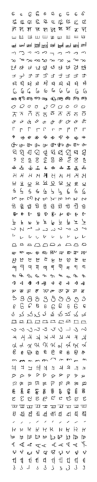

Accuracy: 0.9866666793823242


In [26]:
my_sample = extract_sample(n_way, n_support, n_query, testx, testy)
display_sample(my_sample)
loss, output = model.set_forward_loss(my_sample)
print(f"Accuracy: {output['acc']}")

### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



In [27]:
def predict_visual(sample: dict, model: ProtoNet):
    """
    Для одного sample-а (n_way, n_support+n_query, 3,28,28) строим:
      - прототипы (средняя точка каждого класса по support)
      - признаки всех query
    Затем рисуем t-SNE (2D), где каждый класс — свой цвет.
    """
    model.eval()
    images  = sample["images"]   # (n_way, n_supp+n_query, 3,28,28)
    n_way   = sample["n_way"]
    n_supp  = sample["n_support"]
    n_query = sample["n_query"]

    # разделяем support и query
    x_sup = images[:, :n_supp].contiguous().view(n_way * n_supp, 3,28,28)
    x_q   = images[:, n_supp:].contiguous().view(n_way * n_query, 3,28,28)

    # объединяем для одного прохода
    x_all = torch.cat([x_sup, x_q], dim=0).to(DEVICE)
    f_all = model.encoder(x_all)  # (n_way*n_supp + n_way*n_query, z_dim)

    z_dim = f_all.size(-1)
    # вытаскиваем прототипы
    f_sup = f_all[: n_way * n_supp].view(n_way, n_supp, z_dim)  # (n_way, n_supp, z_dim)
    f_proto = f_sup.mean(dim=1).cpu().detach().numpy()          # (n_way, z_dim)

    # вытаскиваем query
    f_query = f_all[n_way * n_supp:]                             # (n_way*n_query, z_dim)
    f_query = f_query.view(n_way, n_query, z_dim).cpu().detach().numpy()

    # объединяем прототипы и query в один массив для t-SNE:
    # сделаем так: для каждого класса i: сначала i-й прототип, затем его query
    feats = []
    for i in range(n_way):
        feats.append(f_proto[i])                  # (z_dim,)
        for j in range(n_query):
            feats.append(f_query[i, j])           # (z_dim,)
    feats = np.stack(feats, axis=0)               # shape: (n_way*(1+n_query), z_dim)

    # запуск t-SNE
    print("Запускаем t-SNE")
    tsne = TSNE(n_components=2, perplexity=5, random_state=SEED, n_jobs=4)
    feats_2d = tsne.fit_transform(feats)           # (n_way*(1+n_query), 2)

    # Визуализация
    print("Строим scatter plot")
    plt.figure(figsize=(10, 8))
    for cls_id in range(n_way):
        # индексы: прототип на позиции cls_id*(1+n_query),
        # далее его query: cls_id*(1+n_query)+1 ... cls_id*(1+n_query)+n_query
        start = cls_id * (1 + n_query)
        end   = start + 1 + n_query
        plt.scatter(feats_2d[start:end, 0], feats_2d[start:end, 1], label=f"Class {cls_id}")

    plt.legend(fontsize=8)
    plt.title("t-SNE визуализация: первые точки — прототипы, остальные — query")
    plt.grid(True)
    plt.show()

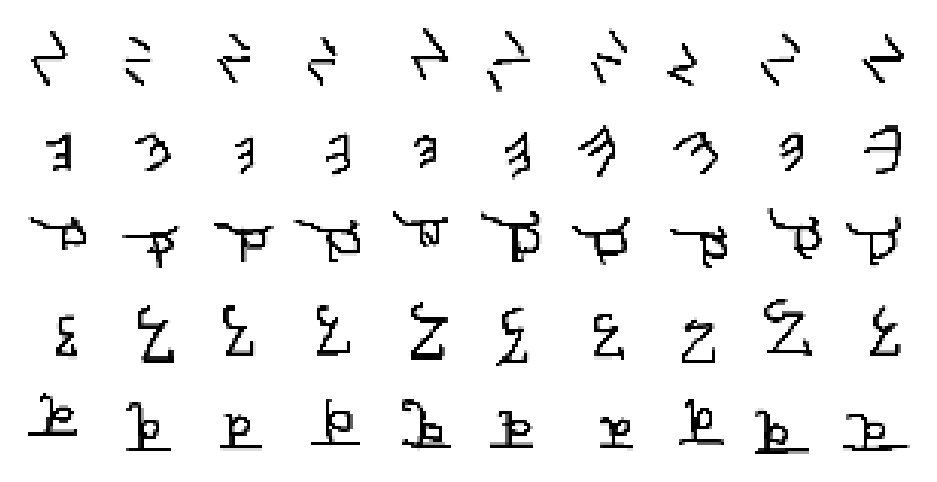

Запускаем t-SNE
Строим scatter plot


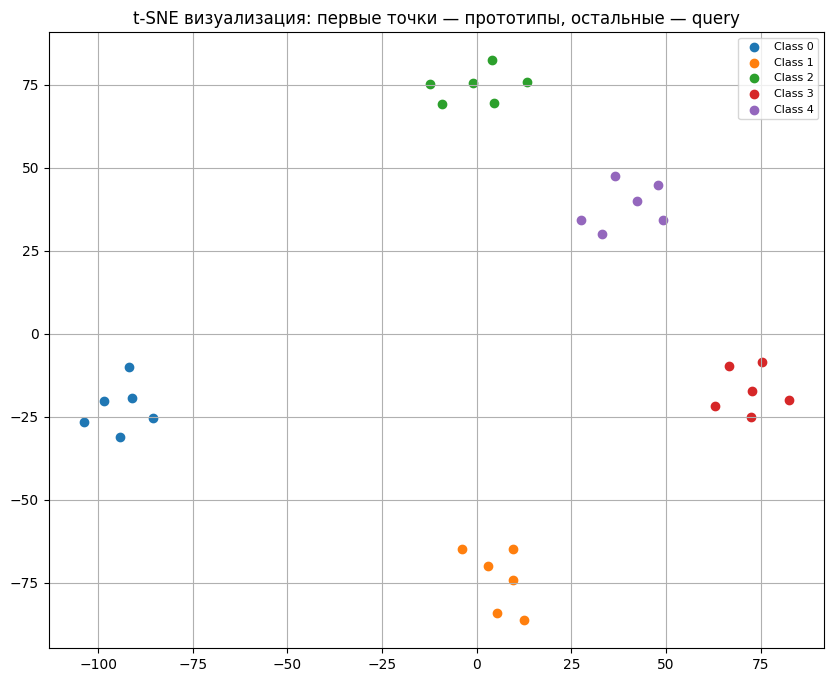

In [28]:
sample_vis = extract_sample(test_n_way, test_n_support, test_n_query, testx, testy)
display_sample(sample_vis)
predict_visual(sample_vis, model)

# Задание 6: Downstream task

## Задание 6.1
Ваша задача обучить заданную вами модель CNN методом SimCLR для набора данных CIFAR10, а затем использовать обученный энкодер для решения задачи классификации.

**Примечание:**
- В качестве базового энкодера можете использовать модель из семинара выше (```resnet18```) или определить свою сеть. **Рекомендуется** использовать уже предобученные сети из [torch zoo](https://pytorch.org/vision/stable/models.html).
- В качестве обучающего множества для задачи классификации воспользуйетсь ```X_test```, ```y_test```, которые были определены в самом начале ноутбука. Создайте обучающую и валидационную выборку.
- В новой CNN для задачи классификации требуется обучить только полносвязные слои после энкодера. Для этого вам потребуется "заморозить" веса энкодера и не учить их. Сделать это можно с помощью команды:
```python
for p in encoder.parameters():
    p.requires_grad = False  
```
- Процесс обучения модели можно взять из предыдущего семинара


In [ ]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    # Три канала -> поэтому три средних и три стандартных отклонения
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

clf_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, hid_dim=512, out_dim=128):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hid_dim, out_dim)
        )

    def forward(self, x):
        # L2‐нормализация по последнему измерению
        return F.normalize(self.proj(x), dim=1)


class SimCLRModel(nn.Module):
    """
    Простая SimCLR-модель на базе ResNet-18 (fc → Identity + ProjectionHead).
    Предполагается, что изображения 32×32 (например, CIFAR-10).
    """
    def __init__(self):
        super().__init__()
        # 1) Сырой энкодер: ResNet-18 без pretrained‐весов
        self.encoder = models.resnet18(pretrained=False)
        # 2) Убираем FC‐слой, оставляем последним выходом features (512)
        self.encoder.fc = nn.Identity()
        # 3) Добавляем «проеkционный хвостик»: 512→512→128
        self.projector = ProjectionHead(in_dim=512)

    def forward(self, x):
        features = self.encoder(x)       # (batch_size, 512)
        projections = self.projector(features)  # (batch_size, 128), L2‐нормализовано
        return projections


In [ ]:
def train_classifier(model, loader, epochs=5, device=DEVICE):
    """
    Универсальная функция для обучения (многоклассового) классификатора.
    Ожидает, что модель на входе выдаёт logits размерности (batch_size, num_classes).
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            out = model(x)                    # logits (batch_size, num_classes)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        epoch_loss = running_loss / total
        epoch_acc  = correct / total
        print(f"Epoch {epoch}: Loss {epoch_loss:.4f}, Acc {epoch_acc:.4f}")


In [ ]:
class DownstreamClassifier(nn.Module):
    """
    Берёт «замороженный» encoder и добавляет один полносвязный слой (z_dim→num_classes).
    В forward сначала вызывает encoder(x) внутри torch.no_grad().
    """
    def __init__(self, encoder: nn.Module, z_dim: int = 512, num_classes: int = 10):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(z_dim, num_classes)

    def forward(self, x):
        # x: (batch, 3,32,32)
        with torch.no_grad():
            z = self.encoder(x.to(next(self.encoder.parameters()).device))  # (batch, z_dim)
        out = self.fc(z)  # (batch, num_classes)
        return out


In [ ]:
# Дёргаем CIFAR-10 (train=True -> 50k изображений).
# Применяем только clf_transform, т.к. здесь мы уже работаем «обычным» классификатором.
full_train = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=clf_transform
)

# Разбиваем на 80% train / 20% val (стратифицировано):
train_size = int(0.8 * len(full_train))
val_size   = len(full_train) - train_size
train_set, val_set = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

batch_size = 128
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train samples: {len(train_set)}, Val samples: {len(val_set)}")


100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Train samples: 40000, Val samples: 10000


## Задание 6.2

Сравните полученный результат обучения c и без использования метода SimCLR.

In [ ]:
# Предполагаем, что обучили SimCLR и сохранили его энкодер в "simclr_encoder.pt"
simclr_model = SimCLRModel().to(DEVICE)
simclr_model.load_state_dict(torch.load("simclr_encoder.pt", map_location=DEVICE))
simclr_model.eval()

# «Замораживаем» энкодер:
frozen_encoder = simclr_model.encoder
for p in frozen_encoder.parameters():
    p.requires_grad = False

# Создаём downstream‐классификатор поверх этого encoder-а:
clf_simclr = DownstreamClassifier(
    encoder = frozen_encoder,
    z_dim    = 512,
    num_classes = 10
).to(DEVICE)

print("Training downstream classifier using frozen SimCLR encoder…")
train_classifier(clf_simclr, train_loader, epochs=5, device=DEVICE)

# (Опционально) после обучения можно вычислить метрики на val_loader

FileNotFoundError: [Errno 2] No such file or directory: 'simclr_encoder.pt'

In [ ]:
# Берём свежий ResNet-18 (без pretrained=False) и убираем fc
random_encoder = models.resnet18(pretrained=False)
random_encoder.fc = nn.Identity()

# Создаём downstream‐классификатор поверх «рандомного» encoder-а:
clf_random = DownstreamClassifier(
    encoder = random_encoder,
    z_dim    = 512,
    num_classes = 10
).to(DEVICE)

print("Training downstream classifier using a random (non‐pretrained) ResNet-18 encoder…")
train_classifier(clf_random, train_loader, epochs=5, device=DEVICE)

Training downstream classifier using a random (non‐pretrained) ResNet-18 encoder…
Epoch 1: Loss 2.0673, Acc 0.2540
Epoch 2: Loss 1.9240, Acc 0.3103
Epoch 3: Loss 1.8930, Acc 0.3226
Epoch 4: Loss 1.8830, Acc 0.3259
Epoch 5: Loss 1.8763, Acc 0.3288
